# Second Project - First Problem

## Train and Validation

### Importing the necessary Libraries

In [1]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import gdown

### Visualizing some of the test data

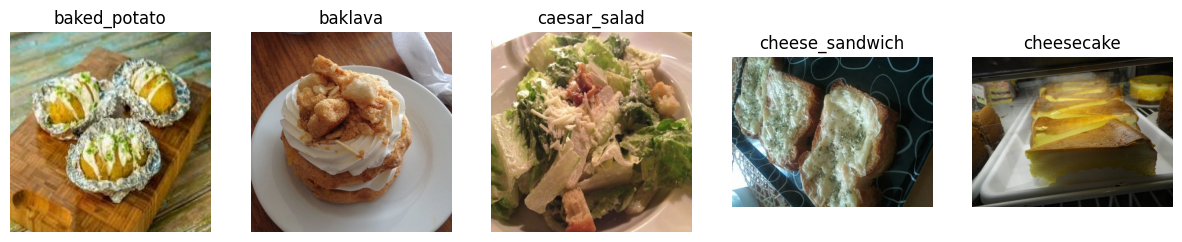

### Settimg the File IDs and adjustments

In [3]:
# ⚙️ Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 15
TRAIN_ZIP_ID = "15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz"
TRAIN_ZIP_PATH = "train_data.zip"
TRAIN_DIR = "data/train"
TEST_ZIP_ID = "1mtigz-kMPtI_IJKUmsG_wqNIhuBFUGdu"
TEST_ZIP_PATH = "test_data.zip"
TEST_DIR = "data/test"
MODEL_PATH = "MobileNetV2_finetuned_final.h5"

### Download, Extraction, Augmentation, Cleaning and Indexing the classes of Training Data

In [4]:
# Download and Extraction
if not os.path.exists(TRAIN_DIR):
    gdown.download(f"https://drive.google.com/uc?id={TRAIN_ZIP_ID}", TRAIN_ZIP_PATH, quiet=False)
    with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall("data")

# Data Cleaning
def clean_directory(directory):
    for root, _, files in os.walk(directory):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                with Image.open(fpath) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError):
                os.remove(fpath)

clean_directory(TRAIN_DIR)

# Data Augmentation
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Train and Validation seperation
train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True
)

val_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# Indexing the classes
num_classes = len(train_data.class_indices)
class_indices = train_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}


Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=175d1bfc-e503-4771-9b7f-9565e4719704
To: /content/train_data.zip
100%|██████████| 898M/898M [00:12<00:00, 71.4MB/s]


Found 19276 images belonging to 22 classes.
Found 4808 images belonging to 22 classes.


### Visualizing Some of the data

In [ ]:
# تابع برای نمایش تصاویر
def display_sample_images(directory, class_indices, num_samples=5):
    classes = list(class_indices.keys())
    selected_images = []
    selected_labels = []
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                selected_image = random.choice(image_files)
                selected_images.append(os.path.join(class_path, selected_image))
                selected_labels.append(class_name)
    # محدود کردن به num_samples تصویر
    selected_images = selected_images[:num_samples]
    selected_labels = selected_labels[:num_samples]
    plt.figure(figsize=(15, 5))
    for i, (img_path, label) in enumerate(zip(selected_images, selected_labels)):
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
        except (UnidentifiedImageError, OSError):
            print(f"⚠️ Skipping corrupt image: {img_path}")
    plt.show()
display_sample_images(TRAIN_DIR, class_indices, num_samples=5)

### Defining, compiling and training the model

We chose MobileNetV2 because it gave us more promising accuracy with less time-cost and showed more potential. The experiment for testing the models are available in Github in form of code and report.


---


We Also saved the best parameters for future refrences and entered a manual F1 Score callback.

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

class F1ScoreCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_labels = []
        for x_batch, y_batch in val_data:
            preds = model.predict(x_batch, verbose=0)
            val_preds.extend(np.argmax(preds, axis=1))
            val_labels.extend(np.argmax(y_batch, axis=1))
            if len(val_labels) >= val_data.samples:
                break
        f1 = f1_score(val_labels, val_preds, average='micro')
        print(f"\n🎯 Validation Micro F1 Score: {f1:.4f}")

callbacks = [
    F1ScoreCallback(),
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, save_best_only=True)
]

model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

## Testing the reporting

### Downloading, Extracting and cleaning the test data

In [ ]:
if not os.path.exists(TEST_DIR):
    gdown.download(f"https://drive.google.com/uc?id={TEST_ZIP_ID}", TEST_ZIP_PATH, quiet=False)
    with zipfile.ZipFile(TEST_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall("data")

clean_directory(TEST_DIR)


### Predicting the classes of test data

In [ ]:
# 🔮 Predict on Test Images
predictions = []
filenames = []
corrupt_files = []

model = keras.models.load_model(MODEL_PATH)

for fname in sorted(os.listdir(TEST_DIR)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    try:
        path = os.path.join(TEST_DIR, fname)
        img = Image.open(path).convert("RGB").resize(IMG_SIZE)
        arr = preprocess_input(img_to_array(img))
        arr = np.expand_dims(arr, axis=0)

        pred = model.predict(arr, verbose=0)
        pred_class = index_to_class[np.argmax(pred[0])]

        filenames.append(fname)
        predictions.append(pred_class)

    except (UnidentifiedImageError, OSError, ValueError):
        corrupt_files.append(fname)


### Reporting the test results

We anticipated that we might have some "bad" data similar to training data. This is where we would report them.

In [ ]:

submission = pd.DataFrame({"name": filenames, "predicted": predictions})
submission.to_csv("submission.csv", index=False)
print("✅ Predictions saved to submission.csv")

if corrupt_files:
    print(f"⚠️ Skipped {len(corrupt_files)} corrupt images:")
    for c in corrupt_files:
        print(" -", c)
else:
    print("✅ No corrupt test images found.")


Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=ce7851b5-4a28-4ca1-a929-84729564cdb0
To: /content/train_data.zip
100%|██████████| 898M/898M [00:16<00:00, 54.8MB/s]


Found 19276 images belonging to 22 classes.
Found 4808 images belonging to 22 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.4381 - loss: 2.0163


🎯 Validation Micro F1 Score: 0.6219
302/302 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.4387 - loss: 2.0143 - val_accuracy: 0.6188 - val_loss: 1.5284
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.7824 - loss: 0.7392


🎯 Validation Micro F1 Score: 0.7107
302/302 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.7824 - loss: 0.7391 - val_accuracy: 0.7157 - val_loss: 1.0685
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8314 - loss: 0.5652


🎯 Validation Micro F1 Score: 0.7627
302/302 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8314 - loss: 0.5651 - val_accuracy: 0.7619 - val_loss: 0.9141
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.8598 - loss: 0.4523


🎯 Validation Micro F1 Score: 0.7964
302/302 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8598 - loss: 0.4523 - val_accuracy: 0.8012 - val_loss: 0.7630
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8883 - loss: 0.3761
🎯 Validation Micro F1 Score: 0.7885
302/302 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8883 - loss: 0.3761 - val_accuracy: 0.7949 - val_loss: 0.7770
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9030 - loss: 0.3102


🎯 Validation Micro F1 Score: 0.8240
302/302 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9030 - loss: 0.3102 - val_accuracy: 0.8228 - val_loss: 0.6562
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9181 - loss: 0.2603


🎯 Validation Micro F1 Score: 0.8386
302/302 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9181 - loss: 0.2604 - val_accuracy: 0.8409 - val_loss: 0.5949
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9290 - loss: 0.2295
🎯 Validation Micro F1 Score: 0.8209
302/302 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9289 - loss: 0.2295 - val_accuracy: 0.8251 - val_loss: 0.7047
Epoch 9/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9369 - loss: 0.2011
🎯 Validation Micro F1 Score: 0.8380
302/302 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9369 - loss: 0.2011 - val_accuracy: 0.8392 - val_loss: 0.6419
Epoch 10/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9439 - loss: 0.1788
🎯 Validation Micro F1 Score: 0.8415
302/302 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.9439 - loss: 0.1788 - val_accuracy: 0.8469 - val_loss: 0.6095


✅ Predictions saved to submission.csv
✅ No corrupt test images found.


### Visualizing the correct and wrong data predictions

In [ ]:
# تابع برای نمایش نمونه‌های درست و نادرست
def display_correct_incorrect_predictions(model, val_data, index_to_class, num_samples=5):
    correct_preds = []
    incorrect_preds = []
    val_images = []
    val_data.reset()
    # گرفتن پیش‌بینی‌ها و برچسب‌ها
    for x_batch, y_batch in val_data:
        preds = model.predict(x_batch, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y_batch, axis=1)

        for i in range(len(pred_classes)):
            img = x_batch[i]
            pred_label = index_to_class[pred_classes[i]]
            true_label = index_to_class[true_classes[i]]
            if pred_label == true_label:
                if len(correct_preds) < num_samples:
                    correct_preds.append((img, pred_label, true_label))
            else:
                if len(incorrect_preds) < num_samples:
                    incorrect_preds.append((img, pred_label, true_label))
            val_images.append(img)

        if len(correct_preds) >= num_samples and len(incorrect_preds) >= num_samples:
            break


    print("✅ Displaying 5 Correct Predictions:")
    plt.figure(figsize=(15, 5))
    for i, (img, pred_label, true_label) in enumerate(correct_preds):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow((img * 255).astype(np.uint8))  # تبدیل تصویر به فرمت نمایش
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()

    print("❌ Displaying 5 Incorrect Predictions:")
    plt.figure(figsize=(15, 5))
    for i, (img, pred_label, true_label) in enumerate(incorrect_preds):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow((img * 255).astype(np.uint8))  # تبدیل تصویر به فرمت نمایش
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()
display_correct_incorrect_predictions(model, val_data, index_to_class, num_samples=5)